# Hubbard Brook Watershed


In [1]:
watershed = 'HubbardBrook'

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import copy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# some_file.py
#import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions')
#import Abnormal_data_values_control 
#from Abnormal_data_values_control import threC
import os
os.getcwd()
os.getcwd().rsplit('/',1)[0]

'/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/13-Hubbard'

In [3]:
def nan_groupby(df, method = 'mean', ratio = 0.1): # 0.1*24=2.4 allow 2 hourly missing data points within 24h (one day)
    groupby_df = pd.DataFrame(columns = df.columns)
    for col in df.columns: 
        df_col = df[[col]]
        for group, data in df_col.groupby(df_col.index.date):
            na_rows = data.shape[0] - data.count()[0]
            total_rows = data.shape[0]
            na_ratio = na_rows/total_rows
            if method == 'mean':
                if 0<na_ratio<ratio: # don't want to waste data in this case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean().values[0]
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", data.mean().values[0])
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean(skipna = False).values[0]     
            if method == 'sum':
                if 0<na_ratio<ratio: # don't want to waste data case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = (data.sum().values[0])/(1-na_ratio) # standardize the value
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", (data.sum().values[0])/(1-na_ratio))
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.sum(skipna = False).values[0]                
    return groupby_df

# function for aggregation(daily) and combination
def aggre_and_comb_daily(lst, axis=1, func = "sum"):
    prep = pd.DataFrame()
    for df in lst:
        if axis == 1:
            if func == "sum":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')
            elif func == "mean":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')        
        elif axis == 0: # concatenate by year
            if func == "sum":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            elif func == "mean":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            prep.index.rename('DateTime', inplace = True)
        prep = prep[prep.index.notnull()]
    print('The final table is:')
    display(prep.head(2))
    display(prep.tail(2))
    prep.index = pd.to_datetime(prep.index,errors = 'coerce')
    return prep

# a case-by-case function where the threshold values could be changed according with different watersheds
def threC(prep,varname):
# This function returns a dataframe without unrealistic values
# This function only deletes unrealistic data, doesn't deal with the outliers
# SR avg is 1361 W/m2 for earth, could be net solar radiation so include negative values  
    thre_dic = {'Discharge':(0,9999999),  # comment here is the threshold values are changed for this case
                'Precipitation':(0,9999), 
                'AirTemperature':(-20,50),
                'SolarRadiation':(-50,1361),
                'RelativeHumidity': (0,100), 
                'WindDirection': (0,365),
                'WindSpeed': (0, 99),
                'SWE': (0,9999),
                'SnowDepth': (0,9999),
                'VaporPressure': (0,101), 
                'SoilMoisture': (0,100),
                'SoilTemperature': (-50,50), ### avoid unreasonable records
                'Isotope': (-9999,9999), 
                'DewPointTemperature': (-100,100), 
                'Snowmelt': (0,9999)
                 }
    thmin = thre_dic[varname][0]
    thmax = thre_dic[varname][1]    
    for i in range(len(prep.columns)):
        col = prep.columns[i]     
        # tranfer the values to be numeric 
        prep[col] = np.array(pd.to_numeric(prep[col], errors='coerce'))        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) < thmin)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0]!=0:     
            print(col,'Out of lower threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)))
            print(col,'Out of lower threshold number:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0])        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) > thmax)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) >thmax)).shape[0]!=0:
            print(col,'Out of upper threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)))
            print(col,'Out of upper threshold number:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)).shape[0])            
    return prep

### Discharge

In [4]:
# Read data
linklist=['https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.1.12&entityid=deab44e37e9d6ea02bcdf558ea78be43',
         'https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.1.12&entityid=312b77e24e6e69310728d3b1b89d6c72',
         'https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.1.12&entityid=20c4cd445d04b36f12f2c37046ffe9ac',
         'https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.1.12&entityid=e81c396f7f5febcf8ef2bddf9349bd75',
         'https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.1.12&entityid=afbc09a3d5bbb77936d8160743b527df',
         'https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.1.12&entityid=2fcf16028734adb37a5f861b6c8c554a',
         'https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.1.12&entityid=362808a41bd501905d9f4edddd4b4437',
         'https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.1.12&entityid=a710350489c21ee972f41d0d4674da9d',
         'https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.1.12&entityid=82e3241132fd9ec678acb9b40c74664e',
         ]
df_lst=[]
for i,link in enumerate(linklist):
    data=pd.read_csv(link,header=0,index_col='DATETIME')
    data=data[['Discharge_ls']]
    data.columns=['WS'+str(i+1)+'_Discharge']
    data.index=pd.to_datetime([i.split(' ')[0] for i in data.index])
    data=threC(data,'Discharge')
    display(data.head())
    df_lst.append(data)
prep1 = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

WS1_Discharge
1956-01-01         0.3766
1956-01-01         0.3710
1956-01-02         0.3710
1956-01-02         0.3540
1956-01-03         0.3455

WS2_Discharge
1957-10-01            0.0
1957-10-01            0.0
1957-10-02            0.0
1957-10-02            0.0
1957-10-03            0.0

WS3_Discharge
1957-10-01         0.1614
1957-10-02         0.1614
1957-10-03         0.1614
1957-10-04         0.1614
1957-10-05         0.1614

WS4_Discharge
1960-07-01         1.8576
1960-07-01         1.8406
1960-07-01         1.5999
1960-07-01         1.3932
1960-07-01         1.1497

WS5_Discharge
1962-01-01         0.9061
1962-01-01         0.9061
1962-01-02         0.9061
1962-01-02         0.9061
1962-01-03         0.9061

WS6_Discharge
1963-01-01         0.7447
1963-01-01         0.7108
1963-01-02         0.6881
1963-01-02         0.7108
1963-01-03         0.7334

WS7_Discharge
1965-01-01        47.0427
1965-01-01        47.0427
1965-01-01        64.0554
1965-01-01        84.2538
1965-01-01        96.9142

WS8_Discharge
1968-05-01        11.4315
1968-05-01        10.8453
1968-05-01        10.2762
1968-05-01         9.9307
1968-05-02         9.6589

WS9_Discharge
1995-01-01         4.8082
1995-01-01         4.8988
1995-01-01         4.8988
1995-01-01         4.8082
1995-01-02         4.7204

The final table is:


WS1_Discharge WS2_Discharge WS3_Discharge WS4_Discharge  \
1956-01-01        0.3738           NaN           NaN           NaN   
1956-01-02        0.3625           NaN           NaN           NaN   

           WS5_Discharge WS6_Discharge WS7_Discharge WS8_Discharge  \
1956-01-01           NaN           NaN           NaN           NaN   
1956-01-02           NaN           NaN           NaN           NaN   

           WS9_Discharge  
1956-01-01           NaN  
1956-01-02           NaN

WS1_Discharge WS2_Discharge WS3_Discharge WS4_Discharge  \
2012-12-30       2.20515       2.71345       6.97104       7.83737   
2012-12-31        1.9156       2.39138        6.5214       7.28022   

           WS5_Discharge WS6_Discharge WS7_Discharge WS8_Discharge  \
2012-12-30       4.45352        1.8569        7.7894        3.9056   
2012-12-31       4.08188       1.78965         8.151       3.64158   

           WS9_Discharge  
2012-12-30       4.78765  
2012-12-31       4.22842

In [5]:
# Read data
linklist=['https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.1.12&entityid=5edc503363b778d630d5148938a6f052',
         'https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.1.12&entityid=0e031ec84b833ed030408f842af48d86',
         'https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.1.12&entityid=8c1915592474108c234fc6265b5a81be',
         'https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.1.12&entityid=c56da977eb8b1639984b1270cf36125f',
         'https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.1.12&entityid=a8ed4ecf683baa810350ffbf7a7bbe1f',
         'https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.1.12&entityid=710a09f15529a1130fe7e9a2eea02270',
         'https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.1.12&entityid=31f150c736e566cda8a77e7cd5c9a5f8',
         'https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.1.12&entityid=374390b79209fc52c86f8188b0e3cfaf',
         'https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.1.12&entityid=53f59746ebe3a9bd0b517ff9b363dffb']
df_lst=[]
for i,link in enumerate(linklist):
    print(i)
    data=pd.read_csv(link,header=0,index_col='DATETIME')
    display(data.head())
    data=data[['Discharge_ls']]
    data.columns=['WS'+str(i+1)+'_Discharge']
    data.index=pd.to_datetime([i.split(' ')[0] for i in data.index])
    data=threC(data,'Discharge')
    display(data.head())
    df_lst.append(data)
prep2 = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

0


WS  Gage_ft  Discharge_cfs  Discharge_ls Flag
DATETIME                                                       
2013-01-01 00:05   1     0.24         0.0697        1.9737  NaN
2013-01-01 00:10   1     0.24         0.0697        1.9737  NaN
2013-01-01 00:15   1     0.24         0.0697        1.9737  NaN
2013-01-01 00:20   1     0.24         0.0697        1.9737  NaN
2013-01-01 00:25   1     0.24         0.0697        1.9737  NaN

WS1_Discharge
2013-01-01         1.9737
2013-01-01         1.9737
2013-01-01         1.9737
2013-01-01         1.9737
2013-01-01         1.9737

1


WS  Gage_ft  Discharge_cfs  Discharge_ls Flag
DATETIME                                                       
2013-01-01 00:05   2      0.2          0.086        2.4352  NaN
2013-01-01 00:10   2      0.2          0.086        2.4352  NaN
2013-01-01 00:15   2      0.2          0.086        2.4352  NaN
2013-01-01 00:20   2      0.2          0.086        2.4352  NaN
2013-01-01 00:25   2      0.2          0.086        2.4352  NaN

WS2_Discharge
2013-01-01         2.4352
2013-01-01         2.4352
2013-01-01         2.4352
2013-01-01         2.4352
2013-01-01         2.4352

2


WS  Gage_ft  Discharge_cfs  Discharge_ls Flag
DATETIME                                                       
2013-01-01 00:05   3      0.3         0.2322        6.5752  NaN
2013-01-01 00:10   3      0.3         0.2322        6.5752  NaN
2013-01-01 00:15   3      0.3         0.2322        6.5752    E
2013-01-01 00:20   3      0.3         0.2322        6.5752    E
2013-01-01 00:25   3      0.3         0.2322        6.5752  NaN

WS3_Discharge
2013-01-01         6.5752
2013-01-01         6.5752
2013-01-01         6.5752
2013-01-01         6.5752
2013-01-01         6.5752

3


WS  Gage_ft  Discharge_cfs  Discharge_ls Flag
DATETIME                                                       
2013-01-01 00:05   4      0.3         0.2322        6.5752  NaN
2013-01-01 00:10   4      0.3         0.2322        6.5752  NaN
2013-01-01 00:15   4      0.3         0.2322        6.5752  NaN
2013-01-01 00:20   4      0.3         0.2322        6.5752  NaN
2013-01-01 00:25   4      0.3         0.2322        6.5752  NaN

WS4_Discharge
2013-01-01         6.5752
2013-01-01         6.5752
2013-01-01         6.5752
2013-01-01         6.5752
2013-01-01         6.5752

4


WS  Gage_ft  Discharge_cfs  Discharge_ls Flag
DATETIME                                                       
2013-01-01 00:05   5     0.33          0.163        4.6156  NaN
2013-01-01 00:10   5     0.33          0.163        4.6156  NaN
2013-01-01 00:15   5     0.33          0.163        4.6156  NaN
2013-01-01 00:20   5     0.33          0.163        4.6156  NaN
2013-01-01 00:25   5     0.33          0.163        4.6156  NaN

WS5_Discharge
2013-01-01         4.6156
2013-01-01         4.6156
2013-01-01         4.6156
2013-01-01         4.6156
2013-01-01         4.6156

5


WS  Gage_ft  Discharge_cfs  Discharge_ls Flag
DATETIME                                                       
2013-01-01 00:05   6     0.23         0.0659        1.8661  NaN
2013-01-01 00:10   6     0.23         0.0659        1.8661  NaN
2013-01-01 00:15   6     0.23         0.0659        1.8661  NaN
2013-01-01 00:20   6     0.23         0.0659        1.8661  NaN
2013-01-01 00:25   6     0.23         0.0659        1.8661  NaN

WS6_Discharge
2013-01-01         1.8661
2013-01-01         1.8661
2013-01-01         1.8661
2013-01-01         1.8661
2013-01-01         1.8661

6


WS  Gage_ft  Discharge_cfs  Discharge_ls Flag
DATETIME                                                       
2013-01-01 00:05   7     0.33         0.2933        8.3053  NaN
2013-01-01 00:10   7     0.33         0.2933        8.3053  NaN
2013-01-01 00:15   7     0.33         0.2933        8.3053  NaN
2013-01-01 00:20   7     0.33         0.2933        8.3053  NaN
2013-01-01 00:25   7     0.33         0.2933        8.3053  NaN

WS7_Discharge
2013-01-01         8.3053
2013-01-01         8.3053
2013-01-01         8.3053
2013-01-01         8.3053
2013-01-01         8.3053

7


WS  Gage_ft  Discharge_cfs  Discharge_ls Flag
DATETIME                                                       
2013-01-01 00:05   8     0.23         0.1211        3.4292  NaN
2013-01-01 00:10   8     0.23         0.1211        3.4292  NaN
2013-01-01 00:15   8     0.23         0.1211        3.4292  NaN
2013-01-01 00:20   8     0.23         0.1211        3.4292  NaN
2013-01-01 00:25   8     0.23         0.1211        3.4292  NaN

WS8_Discharge
2013-01-01         3.4292
2013-01-01         3.4292
2013-01-01         3.4292
2013-01-01         3.4292
2013-01-01         3.4292

8


WS  Gage_ft  Discharge_cfs  Discharge_ls Flag
DATETIME                                                       
2013-01-01 00:05   9     0.25         0.1486        4.2079  NaN
2013-01-01 00:10   9     0.25         0.1486        4.2079  NaN
2013-01-01 00:15   9     0.25         0.1486        4.2079  NaN
2013-01-01 00:20   9     0.25         0.1486        4.2079  NaN
2013-01-01 00:25   9     0.25         0.1486        4.2079  NaN

WS9_Discharge
2013-01-01         4.2079
2013-01-01         4.2079
2013-01-01         4.2079
2013-01-01         4.2079
2013-01-01         4.2079

The final table is:


WS1_Discharge WS2_Discharge WS3_Discharge WS4_Discharge  \
2013-01-01        1.9737       2.24469        6.5752        6.5752   
2013-01-02       1.72934       1.85304       5.66294       5.89985   

           WS5_Discharge WS6_Discharge WS7_Discharge WS8_Discharge  \
2013-01-01        4.6156        1.8661        8.3053        3.4292   
2013-01-02       3.99475        2.0275       7.97653       4.14763   

           WS9_Discharge  
2013-01-01        4.2079  
2013-01-02       3.58602

WS1_Discharge WS2_Discharge WS3_Discharge WS4_Discharge  \
2017-10-07             0             0          0.25       0.17125   
2017-10-08             0             0      0.353264      0.324896   

           WS5_Discharge WS6_Discharge WS7_Discharge WS8_Discharge  \
2017-10-07             0     0.0869792          0.57          0.45   
2017-10-08         0.015      0.187639       1.09042      0.668889   

           WS9_Discharge  
2017-10-07       1.05333  
2017-10-08       1.27681

In [6]:
prep = aggre_and_comb_daily([prep1,prep2], axis=0, func = "mean") 

The final table is:


WS1_Discharge WS2_Discharge WS3_Discharge WS4_Discharge  \
DateTime                                                             
1956-01-01        0.3738           NaN           NaN           NaN   
1956-01-02        0.3625           NaN           NaN           NaN   

           WS5_Discharge WS6_Discharge WS7_Discharge WS8_Discharge  \
DateTime                                                             
1956-01-01           NaN           NaN           NaN           NaN   
1956-01-02           NaN           NaN           NaN           NaN   

           WS9_Discharge  
DateTime                  
1956-01-01           NaN  
1956-01-02           NaN

WS1_Discharge WS2_Discharge WS3_Discharge WS4_Discharge  \
DateTime                                                             
2017-10-07             0             0          0.25       0.17125   
2017-10-08             0             0      0.353264      0.324896   

           WS5_Discharge WS6_Discharge WS7_Discharge WS8_Discharge  \
DateTime                                                             
2017-10-07             0     0.0869792          0.57          0.45   
2017-10-08         0.015      0.187639       1.09042      0.668889   

           WS9_Discharge  
DateTime                  
2017-10-07       1.05333  
2017-10-08       1.27681

WS1_Discharge
WS2_Discharge
WS3_Discharge
WS4_Discharge
WS5_Discharge
WS6_Discharge
WS7_Discharge
WS8_Discharge
WS9_Discharge


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

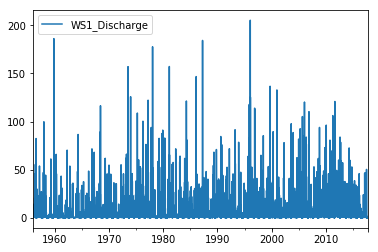

<Figure size 432x288 with 0 Axes>

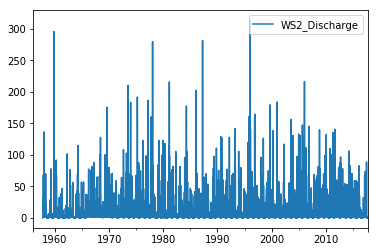

<Figure size 432x288 with 0 Axes>

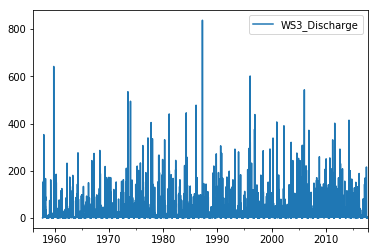

<Figure size 432x288 with 0 Axes>

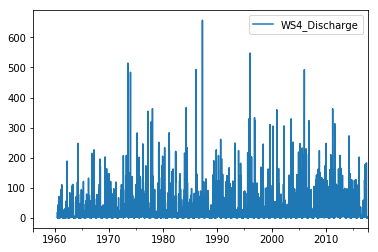

<Figure size 432x288 with 0 Axes>

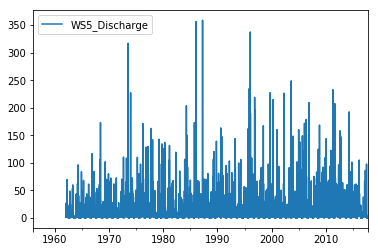

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

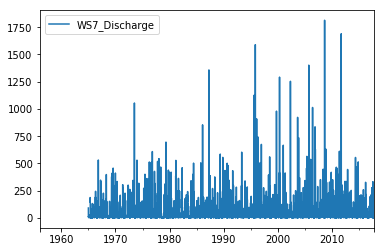

<Figure size 432x288 with 0 Axes>

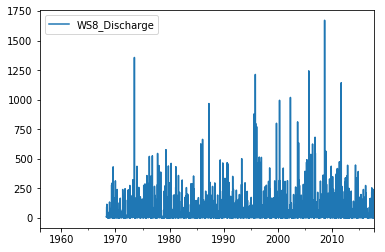

<Figure size 432x288 with 0 Axes>

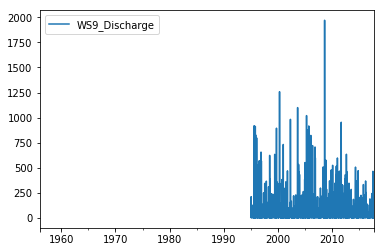

In [7]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Discharge unit should be L/s

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit(m3/s to L/s)
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'Discharge') 
Discharge = copy.deepcopy(df)
Discharge.plot()

### Hydrometeorology

### 2. Precipitation

In [8]:
data = pd.read_csv('https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.14.10&entityid=8f7d90484cf8d687f563d98e1adde6fc',
                    header = 0,index_col = 'Date', parse_dates = True, infer_datetime_format = True)
data.head(5)

WS_1  WS_2  WS_3  WS_4  WS_5  WS_6  WS_7  WS_8  WS_9
Date                                                            
1956-01-01   0.0 -99.9 -99.9 -99.9 -99.9 -99.9 -99.9 -99.9 -99.9
1956-01-02   0.0 -99.9 -99.9 -99.9 -99.9 -99.9 -99.9 -99.9 -99.9
1956-01-03   8.6 -99.9 -99.9 -99.9 -99.9 -99.9 -99.9 -99.9 -99.9
1956-01-04   0.0 -99.9 -99.9 -99.9 -99.9 -99.9 -99.9 -99.9 -99.9
1956-01-05   0.0 -99.9 -99.9 -99.9 -99.9 -99.9 -99.9 -99.9 -99.9

In [9]:
df_lst=[]
for i,col in enumerate(data.columns):
    df=data[[col]]
    df.columns=['WS'+str(i+1)+'_Precipitation']
    display(df.head(3))
    df_lst.append(df)
prep = aggre_and_comb_daily(df_lst, axis=1, func = "sum") 

WS1_Precipitation
Date                         
1956-01-01                0.0
1956-01-02                0.0
1956-01-03                8.6

WS2_Precipitation
Date                         
1956-01-01              -99.9
1956-01-02              -99.9
1956-01-03              -99.9

WS3_Precipitation
Date                         
1956-01-01              -99.9
1956-01-02              -99.9
1956-01-03              -99.9

WS4_Precipitation
Date                         
1956-01-01              -99.9
1956-01-02              -99.9
1956-01-03              -99.9

WS5_Precipitation
Date                         
1956-01-01              -99.9
1956-01-02              -99.9
1956-01-03              -99.9

WS6_Precipitation
Date                         
1956-01-01              -99.9
1956-01-02              -99.9
1956-01-03              -99.9

WS7_Precipitation
Date                         
1956-01-01              -99.9
1956-01-02              -99.9
1956-01-03              -99.9

WS8_Precipitation
Date                         
1956-01-01              -99.9
1956-01-02              -99.9
1956-01-03              -99.9

WS9_Precipitation
Date                         
1956-01-01              -99.9
1956-01-02              -99.9
1956-01-03              -99.9

The final table is:


WS1_Precipitation WS2_Precipitation WS3_Precipitation  \
1956-01-01                 0             -99.9             -99.9   
1956-01-02                 0             -99.9             -99.9   

           WS4_Precipitation WS5_Precipitation WS6_Precipitation  \
1956-01-01             -99.9             -99.9             -99.9   
1956-01-02             -99.9             -99.9             -99.9   

           WS7_Precipitation WS8_Precipitation WS9_Precipitation  
1956-01-01             -99.9             -99.9             -99.9  
1956-01-02             -99.9             -99.9             -99.9

WS1_Precipitation WS2_Precipitation WS3_Precipitation  \
2014-12-30                 0                 0                 0   
2014-12-31                 0                 0                 0   

           WS4_Precipitation WS5_Precipitation WS6_Precipitation  \
2014-12-30                 0                 0                 0   
2014-12-31                 0                 0                 0   

           WS7_Precipitation WS8_Precipitation WS9_Precipitation  
2014-12-30                 0                 0                 0  
2014-12-31                 0                 0                 0

WS1_Precipitation
WS2_Precipitation
WS3_Precipitation
WS4_Precipitation
WS5_Precipitation
WS6_Precipitation
WS7_Precipitation
WS8_Precipitation
WS9_Precipitation


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

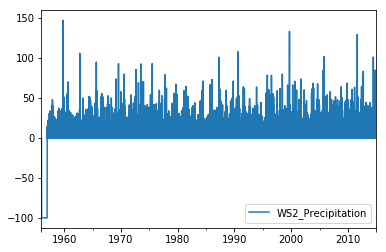

<Figure size 432x288 with 0 Axes>

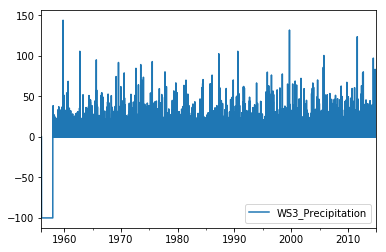

<Figure size 432x288 with 0 Axes>

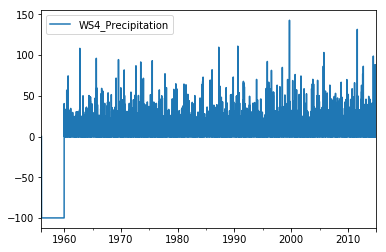

<Figure size 432x288 with 0 Axes>

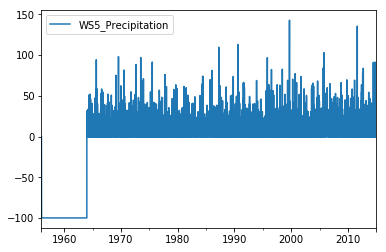

<Figure size 432x288 with 0 Axes>

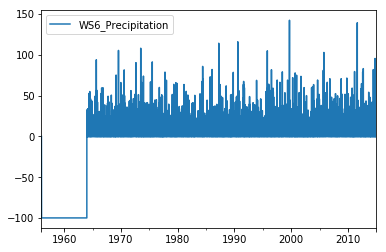

<Figure size 432x288 with 0 Axes>

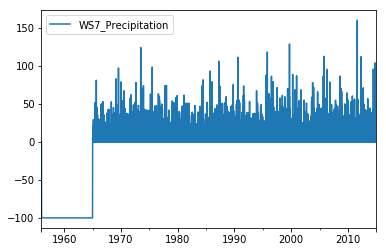

<Figure size 432x288 with 0 Axes>

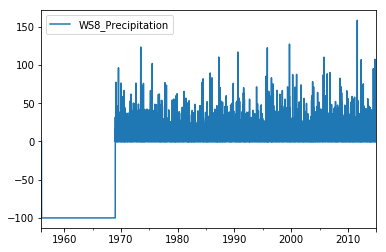

<Figure size 432x288 with 0 Axes>

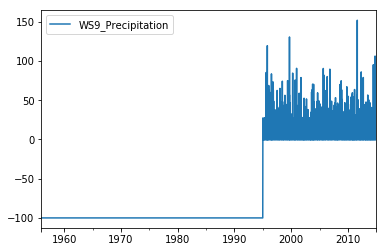

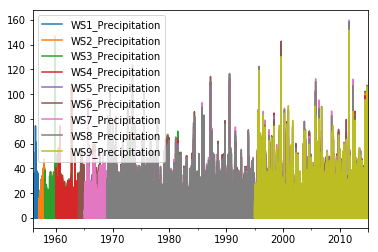

In [10]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Precipitation unit should be mm

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'Precipitation')     
Precipitation = copy.deepcopy(df)
Precipitation.plot()

### 3. AirTemperature

In [11]:
# Daily mean air temperature is wanted
data = pd.read_csv('https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.58.8&entityid=4374c00e247435655401e6d3b7eeb732',
                    header = 0,index_col = 'DATE',parse_dates = True, infer_datetime_format = True)
data.head(5)

STA_1  STA_6  STA_14  STA_1A  STA_HQ  STA_23  STA_17  STA_24
DATE                                                                    
1955-01-01    -99    -99     -99     -99     -99     -99     -99     -99
1955-01-02    -99    -99     -99     -99     -99     -99     -99     -99
1955-01-03    -99    -99     -99     -99     -99     -99     -99     -99
1955-01-04    -99    -99     -99     -99     -99     -99     -99     -99
1955-01-05    -99    -99     -99     -99     -99     -99     -99     -99

In [12]:
df_lst=[]
for i,col in enumerate(data.columns):
    df=data[[col]]
    df.columns=[col.replace('_','')+'_AirTemperature']
    display(df.head(3))
    df = threC(df,'AirTemperature') 
    df_lst.append(df)
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

STA1_AirTemperature
DATE                           
1955-01-01                  -99
1955-01-02                  -99
1955-01-03                  -99

STA6_AirTemperature
DATE                           
1955-01-01                  -99
1955-01-02                  -99
1955-01-03                  -99

STA14_AirTemperature
DATE                            
1955-01-01                   -99
1955-01-02                   -99
1955-01-03                   -99

STA1A_AirTemperature
DATE                            
1955-01-01                   -99
1955-01-02                   -99
1955-01-03                   -99

STAHQ_AirTemperature
DATE                            
1955-01-01                   -99
1955-01-02                   -99
1955-01-03                   -99

STA23_AirTemperature
DATE                            
1955-01-01                   -99
1955-01-02                   -99
1955-01-03                   -99

STA17_AirTemperature
DATE                            
1955-01-01                   -99
1955-01-02                   -99
1955-01-03                   -99

STA24_AirTemperature
DATE                            
1955-01-01                   -99
1955-01-02                   -99
1955-01-03                   -99

The final table is:


STA1_AirTemperature STA6_AirTemperature STA14_AirTemperature  \
1955-01-01                 NaN                 NaN                  NaN   
1955-01-02                 NaN                 NaN                  NaN   

           STA1A_AirTemperature STAHQ_AirTemperature STA23_AirTemperature  \
1955-01-01                  NaN                  NaN                  NaN   
1955-01-02                  NaN                  NaN                  NaN   

           STA17_AirTemperature STA24_AirTemperature  
1955-01-01                  NaN                  NaN  
1955-01-02                  NaN                  NaN

STA1_AirTemperature STA6_AirTemperature STA14_AirTemperature  \
2014-12-30                 -11                 NaN                  NaN   
2014-12-31                 -11                 NaN                  NaN   

           STA1A_AirTemperature STAHQ_AirTemperature STA23_AirTemperature  \
2014-12-30                  NaN                   -9                  NaN   
2014-12-31                  NaN                  -10                  NaN   

           STA17_AirTemperature STA24_AirTemperature  
2014-12-30                  NaN                  NaN  
2014-12-31                  NaN                  NaN

STA1_AirTemperature
STA6_AirTemperature
STA14_AirTemperature
STA1A_AirTemperature
STAHQ_AirTemperature
STA23_AirTemperature
STA17_AirTemperature
STA24_AirTemperature


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

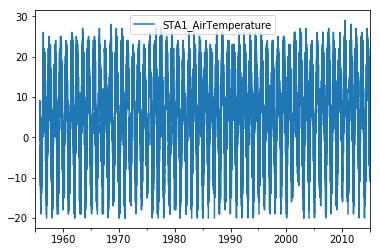

<Figure size 432x288 with 0 Axes>

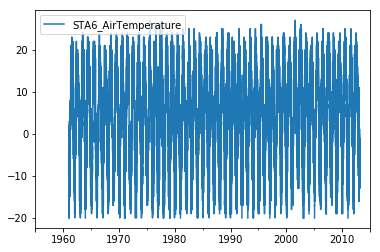

<Figure size 432x288 with 0 Axes>

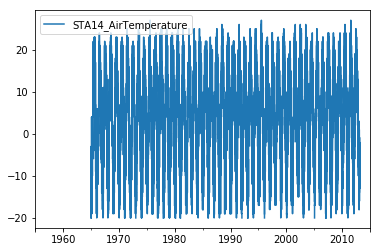

<Figure size 432x288 with 0 Axes>

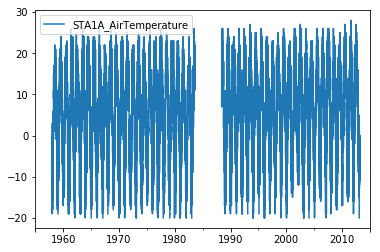

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

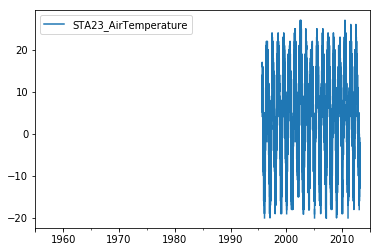

<Figure size 432x288 with 0 Axes>

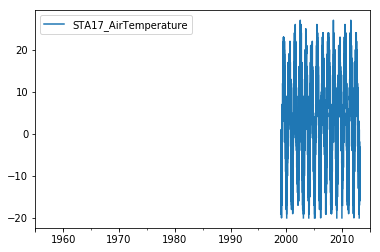

<Figure size 432x288 with 0 Axes>

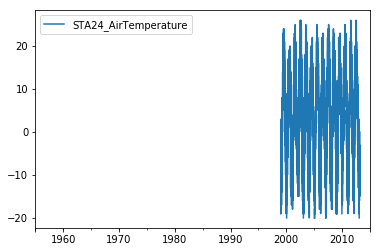

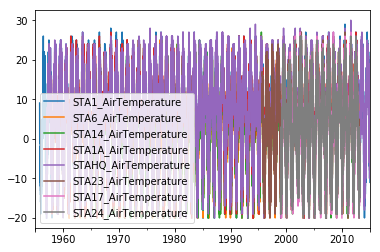

In [13]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Air Temperature unit should be Degree celsius

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'AirTemperature')   
AirTemperature = copy.deepcopy(df)
AirTemperature.plot()

### 4. SolarRadiation

In [14]:
# at weather station 1, near weir 1.
# Daily mean value 
# Unit: Mj/m2
data = pd.read_csv('https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.60.10&entityid=340f7c2dcaedeae68e4a62c281c7350b',
                    header = 0,index_col = 'Date',parse_dates = True, infer_datetime_format = True)
data.head(5)

HQ
Date            
1959-01-01  2.67
1959-01-02  0.67
1959-01-03  0.89
1959-01-04  0.89
1959-01-05  2.63

In [15]:
prep=copy.deepcopy(data)
prep = threC(prep,'SolarRadiation')
prep.columns=['STAHQ_SolarRadiation']

STAHQ_SolarRadiation


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

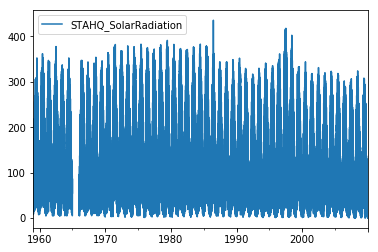

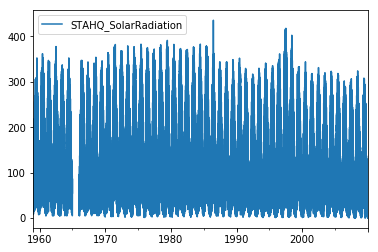

In [16]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! SolarRadiation unit should be W/m2

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*1000000/24/3600  # convert to the right unit
    plt.figure()
    df[[site]].plot()
# plot  
SolarRadiation=copy.deepcopy(df)
SolarRadiation.plot()

### 5. RelativeHumidity

### 6. WindDirection

In [17]:
data = pd.read_csv('https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.56.8&entityid=7e25b972e192b01004b62346ee9975a5',
                    header = 0,index_col = 'Date',parse_dates = True, infer_datetime_format = True)
data.head(5)

TOTAL   S   W   N   E  DEG360 FLAG
Date                                          
1965-10-27  100.0 -99 -99 -99 -99   -99.0  -99
1965-10-28   91.0 -99 -99 -99 -99   -99.0  -99
1965-10-29  168.0 -99 -99 -99 -99   -99.0  -99
1965-10-30   73.0 -99 -99 -99 -99   -99.0  -99
1965-10-31   72.0 -99 -99 -99 -99   -99.0  -99

In [18]:
prep = copy.deepcopy(data[['DEG360']])
prep.columns=['STAHQ_WindDirection']
prep = threC(prep,'WindDirection')

STAHQ_WindDirection


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

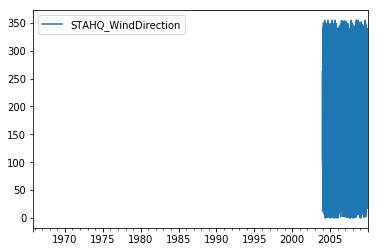

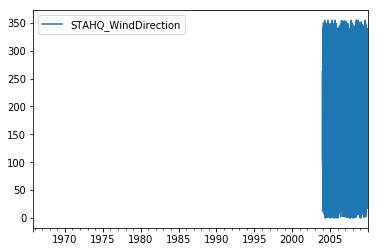

In [19]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! WindDirection unit should be %

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'WindDirection')  
WindDirection = copy.deepcopy(df)
WindDirection.plot()

### 7. WindSpeed

In [20]:
data = pd.read_csv('https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.56.8&entityid=7e25b972e192b01004b62346ee9975a5',
                    header = 0,index_col = 'Date',parse_dates = True, infer_datetime_format = True)
data.head(5)

TOTAL   S   W   N   E  DEG360 FLAG
Date                                          
1965-10-27  100.0 -99 -99 -99 -99   -99.0  -99
1965-10-28   91.0 -99 -99 -99 -99   -99.0  -99
1965-10-29  168.0 -99 -99 -99 -99   -99.0  -99
1965-10-30   73.0 -99 -99 -99 -99   -99.0  -99
1965-10-31   72.0 -99 -99 -99 -99   -99.0  -99

In [21]:
prep = copy.deepcopy(data[['TOTAL']])
prep = threC(prep,'WindSpeed')
prep.columns=['STAHQ_WindSpeed']

STAHQ_WindSpeed


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

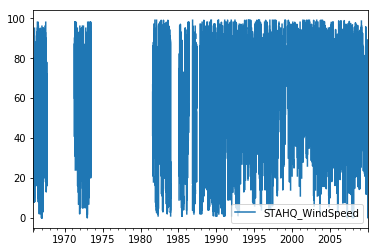

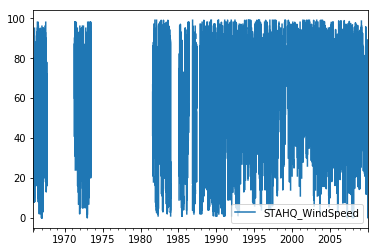

In [22]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! WindSpeed unit should be m/s

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'WindSpeed')  
WindSpeed = copy.deepcopy(df)
WindSpeed.plot()

### 8. SWE

### 9. SnowDepth

In [23]:
data = pd.read_csv('https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.27.12&entityid=efc6724954c772cfe50f3aedc47bc5ca',
                    header = 0,index_col = 'Date',parse_dates = True, infer_datetime_format = True)
data.head(5)

WINTER  STA1  STA2  STA3  STA4  STA5  STA6  STA7  STA8  STA9  ...  \
Date                                                                      ...   
1955-12-05    1956    70    72    92   -99   -99   -99   -99   -99   -99  ...   
1955-12-19    1956    98   113   131   -99   -99   -99   -99   -99   -99  ...   
1956-01-03    1956   133   146   195   -99   -99   -99   -99   -99   -99  ...   
1956-01-09    1956    63   -99   -99   -99   -99   -99   -99   -99   -99  ...   
1956-01-13    1956     6   -99   -99   -99   -99   -99   -99   -99   -99  ...   

            STA12  STA13  STA14  STA15  STA16  STA17  STA19  STA20  STA21  \
Date                                                                        
1955-12-05    -99    -99    -99    -99    -99    -99    -99    -99    -99   
1955-12-19    -99    -99    -99    -99    -99    -99    -99    -99    -99   
1956-01-03    -99    -99    -99    -99    -99    -99    -99    -99    -99   
1956-01-09    -99    -99    -99    -99    -99    -99    -99    -99    -99   
1956-01-13    -99    -99    -99    -99    -99    -99    -99    -99    -99   

            STAHQ  
Date               
1955-12-05    -99  
1955-12-19    -99  
1956-01-03    -99  
1956-01-09    -99  
1956-01-13    -99  

[5 rows x 22 columns]

In [24]:
data.drop(columns=['WINTER'],inplace=True)

In [25]:
df_lst=[]
for i,col in enumerate(data.columns):
    print(col)
    df=data[[col]]
    df.columns=[col+'_SnowDepth']
    display(df.head(3))
    df = threC(df,'SnowDepth')
    df_lst.append(df)
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

STA1


STA1_SnowDepth
Date                      
1955-12-05              70
1955-12-19              98
1956-01-03             133

STA2


STA2_SnowDepth
Date                      
1955-12-05              72
1955-12-19             113
1956-01-03             146

STA3


STA3_SnowDepth
Date                      
1955-12-05              92
1955-12-19             131
1956-01-03             195

STA4


STA4_SnowDepth
Date                      
1955-12-05             -99
1955-12-19             -99
1956-01-03             -99

STA5


STA5_SnowDepth
Date                      
1955-12-05             -99
1955-12-19             -99
1956-01-03             -99

STA6


STA6_SnowDepth
Date                      
1955-12-05             -99
1955-12-19             -99
1956-01-03             -99

STA7


STA7_SnowDepth
Date                      
1955-12-05             -99
1955-12-19             -99
1956-01-03             -99

STA8


STA8_SnowDepth
Date                      
1955-12-05             -99
1955-12-19             -99
1956-01-03             -99

STA9


STA9_SnowDepth
Date                      
1955-12-05             -99
1955-12-19             -99
1956-01-03             -99

STA10


STA10_SnowDepth
Date                       
1955-12-05              -99
1955-12-19              -99
1956-01-03              -99

STA11


STA11_SnowDepth
Date                       
1955-12-05              -99
1955-12-19              -99
1956-01-03              -99

STA12


STA12_SnowDepth
Date                       
1955-12-05              -99
1955-12-19              -99
1956-01-03              -99

STA13


STA13_SnowDepth
Date                       
1955-12-05              -99
1955-12-19              -99
1956-01-03              -99

STA14


STA14_SnowDepth
Date                       
1955-12-05              -99
1955-12-19              -99
1956-01-03              -99

STA15


STA15_SnowDepth
Date                       
1955-12-05              -99
1955-12-19              -99
1956-01-03              -99

STA16


STA16_SnowDepth
Date                       
1955-12-05              -99
1955-12-19              -99
1956-01-03              -99

STA17


STA17_SnowDepth
Date                       
1955-12-05              -99
1955-12-19              -99
1956-01-03              -99

STA19


STA19_SnowDepth
Date                       
1955-12-05              -99
1955-12-19              -99
1956-01-03              -99

STA20


STA20_SnowDepth
Date                       
1955-12-05              -99
1955-12-19              -99
1956-01-03              -99

STA21


STA21_SnowDepth
Date                       
1955-12-05              -99
1955-12-19              -99
1956-01-03              -99

STAHQ


STAHQ_SnowDepth
Date                       
1955-12-05              -99
1955-12-19              -99
1956-01-03              -99

The final table is:


STA1_SnowDepth STA2_SnowDepth STA3_SnowDepth STA4_SnowDepth  \
1955-12-05             70             72             92            NaN   
1955-12-19             98            113            131            NaN   

           STA5_SnowDepth STA6_SnowDepth STA7_SnowDepth STA8_SnowDepth  \
1955-12-05            NaN            NaN            NaN            NaN   
1955-12-19            NaN            NaN            NaN            NaN   

           STA9_SnowDepth STA10_SnowDepth  ... STA12_SnowDepth  \
1955-12-05            NaN             NaN  ...             NaN   
1955-12-19            NaN             NaN  ...             NaN   

           STA13_SnowDepth STA14_SnowDepth STA15_SnowDepth STA16_SnowDepth  \
1955-12-05             NaN             NaN             NaN             NaN   
1955-12-19             NaN             NaN             NaN             NaN   

           STA17_SnowDepth STA19_SnowDepth STA20_SnowDepth STA21_SnowDepth  \
1955-12-05             NaN             NaN             NaN             NaN   
1955-12-19             NaN             NaN             NaN             NaN   

           STAHQ_SnowDepth  
1955-12-05             NaN  
1955-12-19             NaN  

[2 rows x 21 columns]

STA1_SnowDepth STA2_SnowDepth STA3_SnowDepth STA4_SnowDepth  \
2015-04-20            NaN              0            NaN            NaN   
2015-04-27            NaN              0            NaN            NaN   

           STA5_SnowDepth STA6_SnowDepth STA7_SnowDepth STA8_SnowDepth  \
2015-04-20            NaN            NaN            NaN            NaN   
2015-04-27            NaN            NaN            NaN            NaN   

           STA9_SnowDepth STA10_SnowDepth  ... STA12_SnowDepth  \
2015-04-20             14             NaN  ...             NaN   
2015-04-27              0             NaN  ...             NaN   

           STA13_SnowDepth STA14_SnowDepth STA15_SnowDepth STA16_SnowDepth  \
2015-04-20             NaN             NaN             NaN             NaN   
2015-04-27             NaN             NaN             NaN             NaN   

           STA17_SnowDepth STA19_SnowDepth STA20_SnowDepth STA21_SnowDepth  \
2015-04-20             272              58             NaN             NaN   
2015-04-27               0               0             NaN             NaN   

           STAHQ_SnowDepth  
2015-04-20               0  
2015-04-27               0  

[2 rows x 21 columns]

STA1_SnowDepth
STA2_SnowDepth
STA3_SnowDepth
STA4_SnowDepth
STA5_SnowDepth
STA6_SnowDepth
STA7_SnowDepth
STA8_SnowDepth
STA9_SnowDepth
STA10_SnowDepth
STA11_SnowDepth
STA12_SnowDepth
STA13_SnowDepth
STA14_SnowDepth
STA15_SnowDepth
STA16_SnowDepth
STA17_SnowDepth
STA19_SnowDepth
STA20_SnowDepth
STA21_SnowDepth
STAHQ_SnowDepth


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

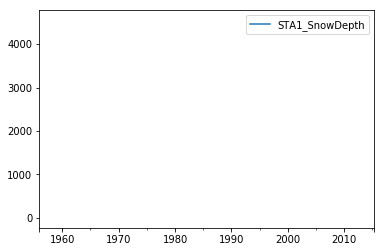

<Figure size 432x288 with 0 Axes>

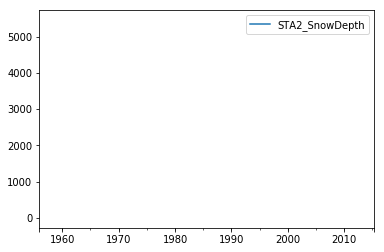

<Figure size 432x288 with 0 Axes>

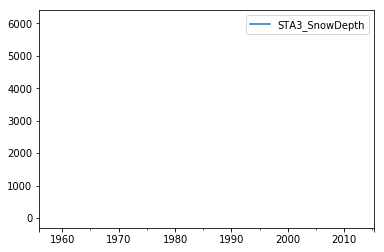

<Figure size 432x288 with 0 Axes>

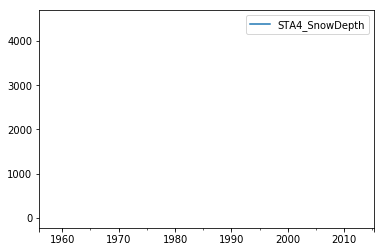

<Figure size 432x288 with 0 Axes>

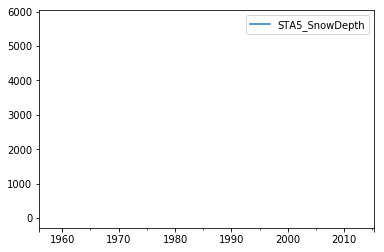

<Figure size 432x288 with 0 Axes>

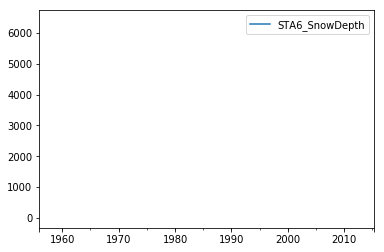

<Figure size 432x288 with 0 Axes>

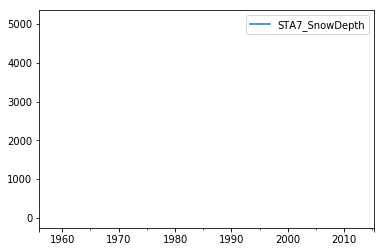

<Figure size 432x288 with 0 Axes>

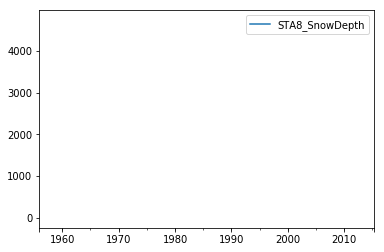

<Figure size 432x288 with 0 Axes>

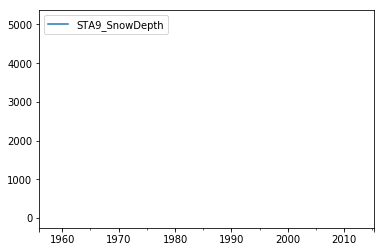

<Figure size 432x288 with 0 Axes>

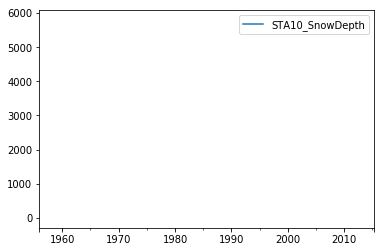

<Figure size 432x288 with 0 Axes>

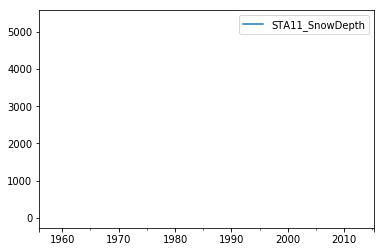

<Figure size 432x288 with 0 Axes>

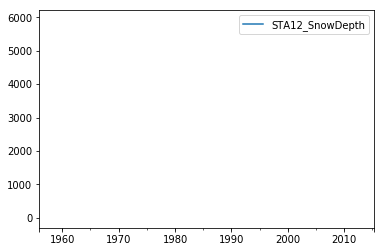

<Figure size 432x288 with 0 Axes>

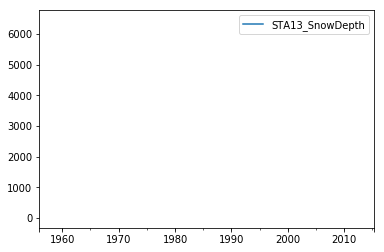

<Figure size 432x288 with 0 Axes>

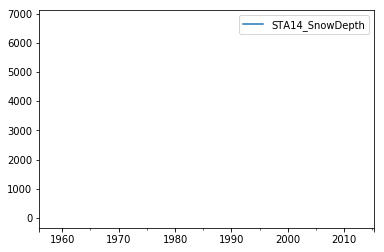

<Figure size 432x288 with 0 Axes>

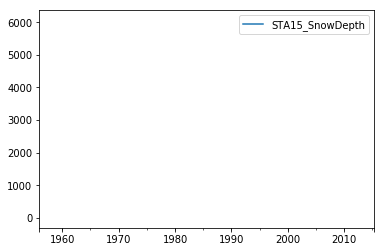

<Figure size 432x288 with 0 Axes>

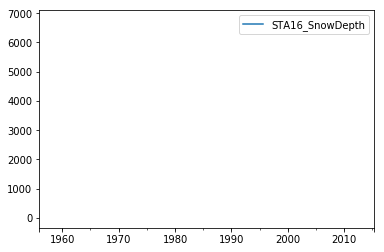

<Figure size 432x288 with 0 Axes>

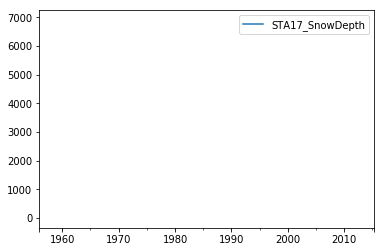

<Figure size 432x288 with 0 Axes>

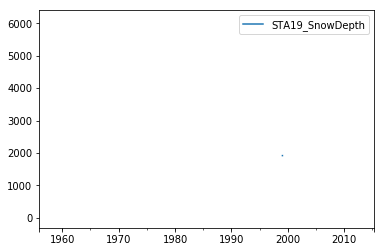

<Figure size 432x288 with 0 Axes>

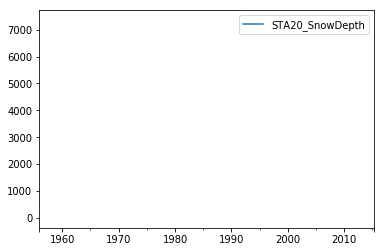

<Figure size 432x288 with 0 Axes>

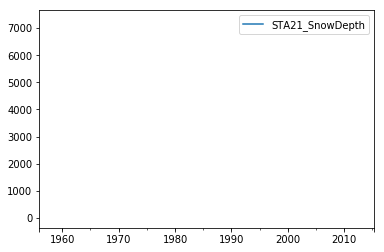

<Figure size 432x288 with 0 Axes>

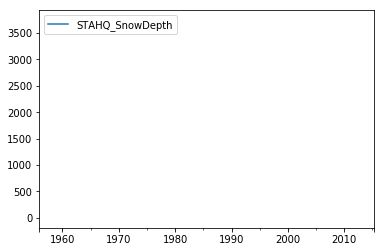

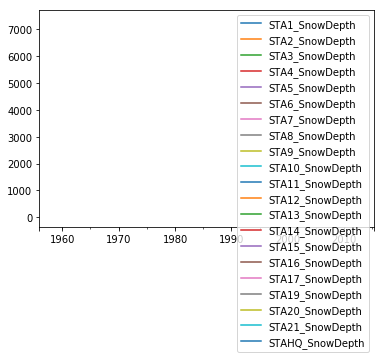

In [26]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Snowdepth unit should be mm

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*10  # convert to the right unit to mm
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'SnowDepth')  
SnowDepth = copy.deepcopy(df)
SnowDepth.plot()

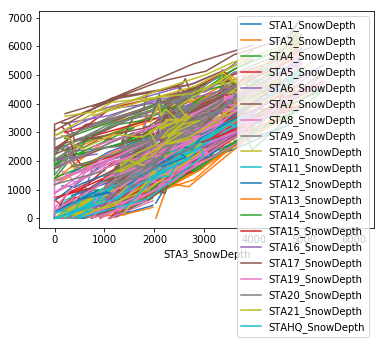

In [27]:
SnowDepth.dropna(how = 'all',inplace = True)
SnowDepth.plot(2)
# not daily data

### 10. VaporPressure

In [28]:
data = pd.read_csv('https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.57.8&entityid=08f41e2b56730d87f1232d525303ba14',
                    header = 0,index_col = 'Date',parse_dates = True, infer_datetime_format = True)
data.head()

VP FLAG
Date                 
1966-01-01  0.23  -99
1966-01-02  0.21  -99
1966-01-03  0.18  -99
1966-01-04  0.16  -99
1966-01-05  0.35  -99

In [29]:
prep = copy.deepcopy(data[['VP']])
prep.columns=['STAHQ_VaporPressure']
prep = threC(prep,'VaporPressure')

STAHQ_VaporPressure


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

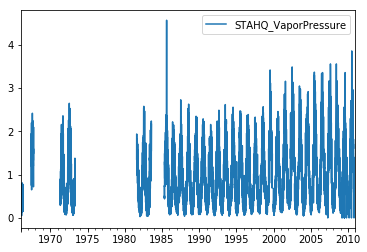

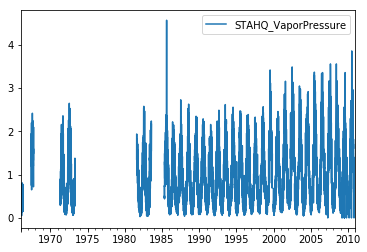

In [30]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! VaporPressure data should be kPa

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'VaporPressure')      
VaporPressure = copy.deepcopy(df)
VaporPressure.plot()

### 11. SoilTemperature

In [31]:
# Colman temperature-moisture sensors were installed at one location west of weir 4 
# and replicated (1 and 2) at depths of 3, 8, 15, 30, 46 and 61 cm.
data = pd.read_csv('https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.65.7&entityid=167dfec6e8a18ab7d16afec11a7923d7',
                    header = 0,index_col = 'DATE',parse_dates = True, infer_datetime_format = True)
data.head(5)

DEPTH  STACK1  STACK2
DATE                             
1959-08-04      3    16.2    18.3
1959-08-04      8    15.7    15.3
1959-08-04     15    14.8    15.3
1959-08-04     30    15.2    15.2
1959-08-04     46    14.2    14.8

In [32]:
df_lst=[]
for d in data['DEPTH'].unique():
    df=data[data['DEPTH']==d]
    display(df.head())

DEPTH  STACK1  STACK2
DATE                             
1959-08-04      3    16.2    18.3
1959-09-01      3    23.3    23.4
1959-09-08      3    22.1    24.0
1959-09-22      3    17.8    17.8
1959-10-07      3    13.3    11.4

DEPTH  STACK1  STACK2
DATE                             
1959-08-04      8    15.7    15.3
1959-09-01      8    21.6    21.1
1959-09-08      8    20.4    20.5
1959-09-22      8    15.7    15.8
1959-10-07      8     8.7     7.0

DEPTH  STACK1  STACK2
DATE                             
1959-08-04     15    14.8    15.3
1959-09-01     15    19.4    20.0
1959-09-08     15    17.8    18.3
1959-09-22     15    13.3    14.3
1959-10-07     15    12.8     9.2

DEPTH  STACK1  STACK2
DATE                             
1959-08-04     30    15.2    15.2
1959-09-01     30    18.3    18.3
1959-09-08     30    17.2    17.2
1959-09-22     30    13.3    13.3
1959-10-07     30    13.3    13.3

DEPTH  STACK1  STACK2
DATE                             
1959-08-04     46    14.2    14.8
1959-09-01     46    16.2    16.3
1959-09-08     46    16.2    15.8
1959-09-22     46    11.4    11.9
1959-10-07     46    13.8    12.8

DEPTH  STACK1  STACK2
DATE                             
1959-08-04     61    13.8    14.8
1959-09-01     61    14.3    15.3
1959-09-08     61    14.7    15.3
1959-09-22     61    11.4    12.4
1959-10-07     61    13.3    12.8

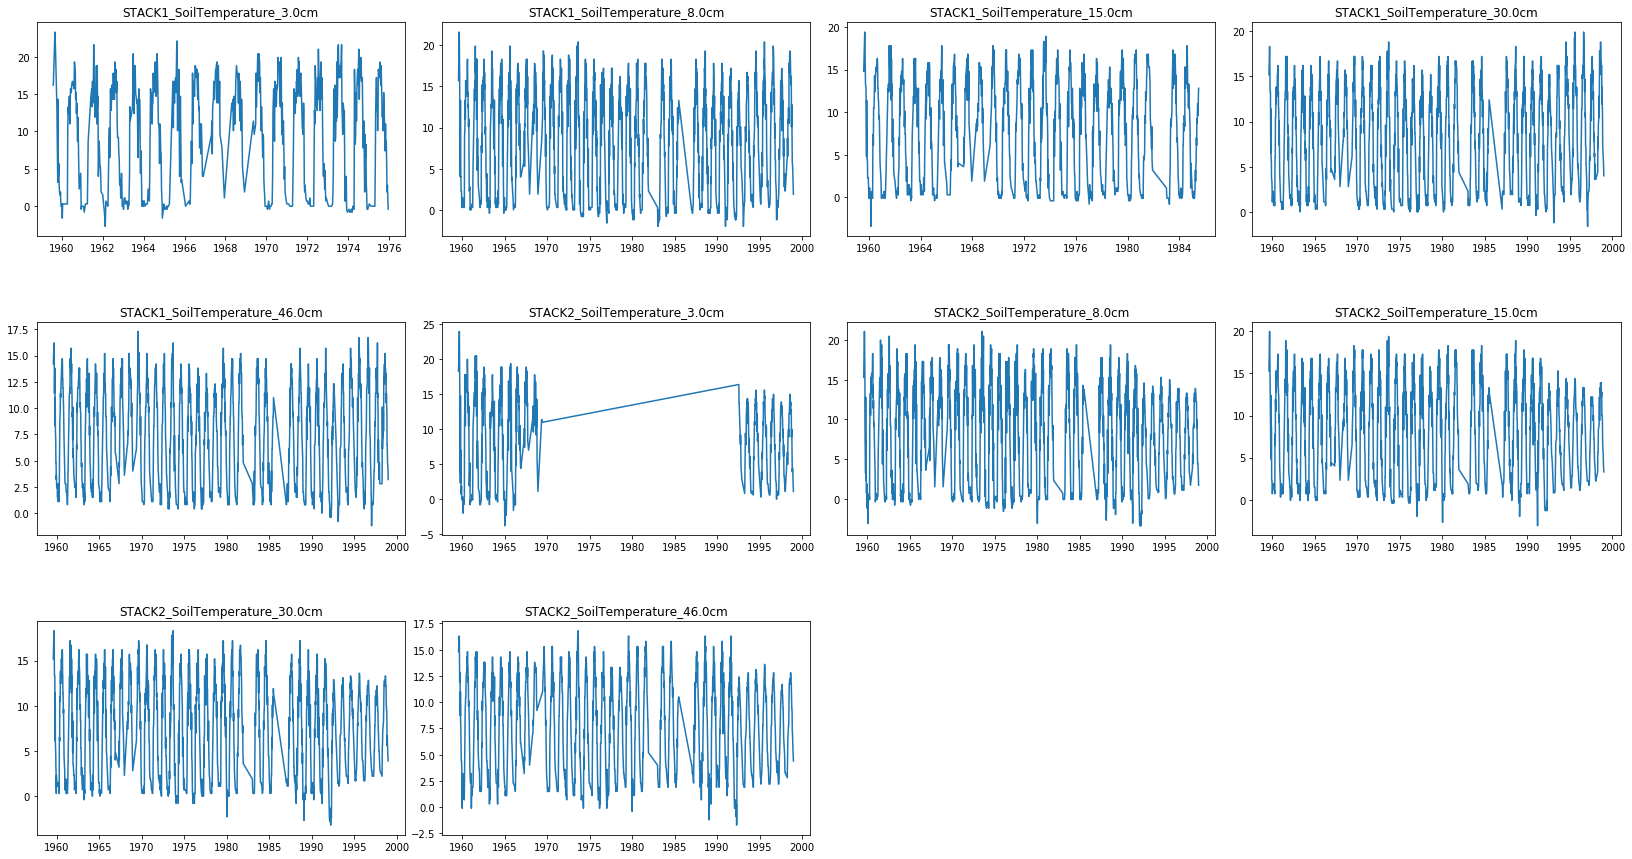

In [34]:
# ST is weekly data
prep = copy.deepcopy(data) #######
prep = threC(prep,'SoilTemperature')
indexUnique = pd.date_range(start='8/4/1959', end='1998-12-31')########

siteList = pd.unique(prep.columns)[1:]
HeightList = pd.unique(prep.DEPTH)

ready_columns = np.array(np.ones(len(siteList)*(len(HeightList)-1)))
ready_columns = ready_columns.astype(str)
m = 0

# Generate unique column name. 
for ii in np.arange(len(siteList)):
    for jj in np.arange(len(HeightList)-1):
        ready_columns[m] = siteList[ii] + '_SoilTemperature_' + np.str(HeightList[jj])+'cm'
        m = m+1

# Initialize a table
NAN = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(NAN, index=indexUnique, columns=ready_columns) # create an empty data frame
m = 0

# Collect the data.
plt.figure(figsize=(10,8))
for ii in np.arange(len(siteList)):   
    for jj in np.arange(len(HeightList)-1):
        site_filter = siteList[ii]        # filter site name
        height_filter = HeightList[jj]     # flter height
        tab = prep [ prep ['DEPTH'] == height_filter ]
        tab = tab.filter(items=[site_filter])
        
        for k in np.arange(len(tab)):
            df.loc[tab.index[k]][ready_columns[m]] = tab.iloc[k,0] # Name of the column
            
        plt.subplot(5,4,m+1)  
        plt.plot(df.iloc[:,m].dropna())
        plt.title(ready_columns[m])
        m = m+1
        
plt.subplots_adjust(top=2.500, bottom=0.05, left=0.0, right=2.2, hspace=0.4,wspace=0.10)   
    
# Plot the data
#df.dropna(how='all',inplace = True)
SoilTemperature = copy.deepcopy(df.dropna(how = 'all')) # Name of variable
SoilTemperature.plot()


### 13. Isotope

In [35]:
# Sulfate isotopes in precipitation and streamwater
data = pd.read_csv('https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-hbr.223.1&entityid=69321e38d543569c163f5c2700f09454',
                    header = 0,index_col = 'collection_date',parse_dates = True, infer_datetime_format = True)
data.head(5)

sample_id    site    sample_type collection_time precip_type  \
collection_date                                                                 
2006-10-31       PFJC-0001  W3_STR         Stream           14:50         NaN   
2006-11-01       PFJC-0002  W3_STR         Stream           11:40         NaN   
2006-11-10       PFJC-0003  W3_STR         Stream           12:20         NaN   
2006-11-13       PFJC-0004  W3_STR         Stream           13:32         NaN   
2006-11-13       PFJC-0005  W3_PRE  Precipitation           12:40        Rain   

                  d18O    d2H  \
collection_date                 
2006-10-31      -10.49 -72.13   
2006-11-01      -10.49 -73.68   
2006-11-10      -10.83 -72.13   
2006-11-13      -10.95 -74.09   
2006-11-13       -9.94 -67.44   

                                                          comments  
collection_date                                                     
2006-10-31                                                     NaN  
2006-11-01                                                     NaN  
2006-11-10                                                     NaN  
2006-11-13                                                     NaN  
2006-11-13       Set up as snow collector; no mineral oil in sa...

In [36]:
def pivot(df, id_col='SITECODE', source='discharge'):
    df.index = pd.to_datetime(df.index)
    result = pd.DataFrame()
    for i, site in enumerate(df[id_col].unique()):
        #print(i)
        #print(site)
        df_H = copy.deepcopy(df[df[id_col]==site][['d2H']])
        df_H = df_H.groupby(df_H.index.date).mean()
        df_O = copy.deepcopy(df[df[id_col]==site][['d18O']])
        df_O = df_O.groupby(df_O.index.date).mean()
        #display(df_H.shape)
        site_name = site.split('_')[0]
        df_H.columns = [site_name + '_Isotope_δ2H_' + source]
        df_O.columns = [site_name + '_Isotope_δ18O_' + source]
        result = copy.deepcopy(result.join(df_H, how = 'outer'))
        result = copy.deepcopy(result.join(df_O, how = 'outer'))
        display(result.head())
    return result

In [37]:
iso_dis=pivot(data[data['sample_type']=='Stream'], id_col='site', source='discharge')

W3_Isotope_δ2H_discharge  W3_Isotope_δ18O_discharge
2006-10-31                    -72.13                    -10.490
2006-11-01                    -73.68                    -10.490
2006-11-10                    -72.13                    -10.830
2006-11-13                    -74.09                    -10.950
2006-11-30                    -70.89                    -10.355

In [38]:
iso_ppt=pivot(data[data['sample_type']=='Precipitation'], id_col='site', source='Precipitation')

W3_Isotope_δ2H_Precipitation  W3_Isotope_δ18O_Precipitation
2006-11-13                        -67.44                          -9.94
2006-11-30                        -36.06                          -5.45
2006-12-22                        -45.10                          -7.11
2006-12-29                        -92.97                         -12.92
2007-01-19                        -82.05                         -11.09

In [39]:
Isotope = copy.deepcopy(iso_dis.join(iso_ppt, how = 'outer'))
Isotope.index=pd.to_datetime(Isotope.index)
Isotope.plot()

# Results

In [40]:
# Put all the tables to the same date format
# data_soil.index= pd.to_datetime(data_soil.index, format= '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') #%-H:%M:%S
# data.index= pd.to_datetime(data.index, format= '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') #%-H:%M:%S
# data_lwr.index= pd.to_datetime(data_lwr.index, format= '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') #%-H:%M:%S

# Bring them together
result = pd.concat([Discharge,Precipitation, AirTemperature,SolarRadiation,WindDirection,
                          WindSpeed,VaporPressure], axis=1,
                    join='outer')

In [41]:
result.index.rename('DateTime',inplace=True)
result.head(3)

WS1_Discharge  WS2_Discharge  WS3_Discharge  WS4_Discharge  \
DateTime                                                                 
1955-01-01            NaN            NaN            NaN            NaN   
1955-01-02            NaN            NaN            NaN            NaN   
1955-01-03            NaN            NaN            NaN            NaN   

            WS5_Discharge  WS6_Discharge  WS7_Discharge  WS8_Discharge  \
DateTime                                                                 
1955-01-01            NaN            NaN            NaN            NaN   
1955-01-02            NaN            NaN            NaN            NaN   
1955-01-03            NaN            NaN            NaN            NaN   

            WS9_Discharge  WS1_Precipitation  ...  STA14_AirTemperature  \
DateTime                                      ...                         
1955-01-01            NaN                NaN  ...                 -16.0   
1955-01-02            NaN                NaN  ...                   NaN   
1955-01-03            NaN                NaN  ...                   NaN   

            STA1A_AirTemperature  STAHQ_AirTemperature  STA23_AirTemperature  \
DateTime                                                                       
1955-01-01                 -13.0                 -10.0                   NaN   
1955-01-02                   NaN                   NaN                   NaN   
1955-01-03                   NaN                   NaN                   NaN   

            STA17_AirTemperature  STA24_AirTemperature  STAHQ_SolarRadiation  \
DateTime                                                                       
1955-01-01                   NaN                   NaN                   NaN   
1955-01-02                   NaN                   NaN                   NaN   
1955-01-03                   NaN                   NaN                   NaN   

            STAHQ_WindDirection  STAHQ_WindSpeed  STAHQ_VaporPressure  
DateTime                                                               
1955-01-01                  NaN              NaN                  NaN  
1955-01-02                  NaN              NaN                  NaN  
1955-01-03                  NaN              NaN                  NaN  

[3 rows x 30 columns]

In [42]:
result.to_csv('1_HubbardBrook_Download_Aggregation_Daily.csv', sep=',')

In [43]:
Isotope.index.rename('DateTime',inplace=True)
Isotope.head(3)

W3_Isotope_δ2H_discharge  W3_Isotope_δ18O_discharge  \
DateTime                                                          
2006-10-31                    -72.13                     -10.49   
2006-11-01                    -73.68                     -10.49   
2006-11-10                    -72.13                     -10.83   

            W3_Isotope_δ2H_Precipitation  W3_Isotope_δ18O_Precipitation  
DateTime                                                                 
2006-10-31                           NaN                            NaN  
2006-11-01                           NaN                            NaN  
2006-11-10                           NaN                            NaN

In [44]:
Isotope.to_csv('1_HubbardBrook_Download_Aggregation_Isotope.csv',sep = ',')